In [1]:
import argparse
import copy
from itertools import product
from pathlib import Path

import pyscf
import torch
import numpy as np
import opt_einsum as oe
from torch.utils.data import DataLoader

from cadft import CC_DFT_DATA, add_args, gen_logger, MAIN_PATH
from cadft.utils import Mol
from cadft.utils import ModelDict


AU2KCALMOL = 627.5096080306


def process(data, dtype):
    """
    Load the whole data to the gpu.
    """
    if len(data.shape) == 4:
        return data.to(
            device="cuda",
            dtype=dtype,
            memory_format=torch.channels_last,
        )
    else:
        return data.to(
            device="cuda",
            dtype=dtype,
        )


class BasicDataset:
    """
    Documentation for a class.
    """

    def __init__(self, input_, weight_, batch_size, dtype):
        self.input = input_
        self.weight = weight_
        self.ids = list(input_.keys())
        self.batch_size = batch_size
        if dtype == "float32":
            self.dtype = torch.float32
        else:
            self.dtype = torch.float64

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return {
            "input": self.input[self.ids[idx]],
            "weight": self.weight[self.ids[idx]],
        }

    def load_to_gpu(self):
        """
        Load the whole data to the device.
        """
        dataloader = DataLoader(
            self,
            shuffle=False,
            batch_size=self.batch_size,
            num_workers=1,
            pin_memory=True,
        )

        dataloader_gpu = []
        for batch in dataloader:
            batch_gpu = {}
            # move images and labels to correct device and type
            (
                batch_gpu["input"],
                batch_gpu["weight"],
            ) = (
                process(batch["input"], self.dtype),
                process(batch["weight"], self.dtype),
            )
            dataloader_gpu.append(batch_gpu)
        return dataloader_gpu


class DIIS:
    """
    DIIS for the Fock matrix.
    """

    def __init__(self, nao, n=50):
        self.n = n
        self.errors = np.zeros((n, nao, nao))
        self.mat_fock = np.zeros((n, nao, nao))
        self.step = 0

    def add(self, mat_fock, error):
        self.mat_fock = np.roll(self.mat_fock, -1, axis=0)
        self.mat_fock[-1, :, :] = mat_fock
        self.errors = np.roll(self.errors, -1, axis=0)
        self.errors[-1, :, :] = error

    def hybrid(self):
        self.step += 1
        mat = np.zeros((self.n + 1, self.n + 1))
        mat[:-1, :-1] = np.einsum("inm,jnm->ij", self.errors, self.errors)
        mat[-1, :] = -1
        mat[:, -1] = -1
        mat[-1, -1] = 0

        b = np.zeros(self.n + 1)
        b[-1] = -1

        if self.step < self.n:
            c = np.linalg.solve(
                mat[-(self.step + 1) :, -(self.step + 1) :], b[-(self.step + 1) :]
            )
            mat_fock = np.sum(
                c[:-1, np.newaxis, np.newaxis] * self.mat_fock[-self.step :], axis=0
            )
            return mat_fock
        else:
            c = np.linalg.solve(mat, b)
            mat_fock = np.sum(c[:-1, np.newaxis, np.newaxis] * self.mat_fock, axis=0)
            return mat_fock

/home/dhem/anaconda3/envs/pyscf/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basis = "cc-pCVDZ"
name_mol_l = ["allene"]
# name_mol_l = ["ethane"]

model_data = "2024-07-10-13-22-52"
# model_data = "2024-06-26-00-16-07"
# model_data = "2024-07-09-21-49-30"

# 1. Init the model
modeldict = ModelDict(
    model_data,
    1,
    64,
    1,
    4,
    0,
    device,
    "float64",
    if_mkdir=False,
)
modeldict.load_model()

for key in ["1", "2"]:
    modeldict.model_dict[key].eval()

# 2. Test loop
distance_l = [0]
for (
    name_mol,
    extend_atom,
    extend_xyz,
    distance,
) in product(
    name_mol_l,
    [0],
    [1],
    distance_l,
):
    # 2.0 Prepare

    molecular = copy.deepcopy(Mol[name_mol])
    print(f"Generate {name_mol}_{distance:.4f}")
    print(f"Extend {extend_atom} {extend_xyz} {distance:.4f}")
    print(molecular)

    name = f"{name_mol}_{basis}_{extend_atom}_{extend_xyz}_{distance:.4f}"
    if abs(distance) < 1e-3:
        if (extend_atom != 0) or extend_xyz != 1:
            print(f"Skip: {name:>40}")
            continue

    if extend_atom >= len(Mol[name_mol]):
        print(f"Skip: {name:>40}")
        continue

    molecular[extend_atom][extend_xyz] += distance
    if (Path(f"{MAIN_PATH}/data/grids_mrks/") / f"data_{name}.npz").exists():
        data_real = np.load(Path(f"{MAIN_PATH}/data/grids_mrks/") / f"data_{name}.npz")
    else:
        print(f"No file: {name:>40}")
        data_real = None

    dft2cc = CC_DFT_DATA(
        molecular,
        name=name,
        basis=basis,
        if_basis_str=True,
    )
    dft2cc.test_mol()
    print(dft2cc.mol.basis)
    nocc = dft2cc.mol.nelec[0]
    diis = DIIS(dft2cc.mol.nao, n=8)

    # 2.1 SCF loop to get the density matrix

    dm1_scf = dft2cc.dm1_dft
    oe_fock = oe.contract_expression(
        "p,p,pa,pb->ab",
        np.shape(dft2cc.ao_0[:, 0]),
        np.shape(dft2cc.ao_0[:, 0]),
        dft2cc.ao_0,
        dft2cc.ao_0,
        constants=[2, 3],
        optimize="optimal",
    )

    for i in range(2500):
        input_mat = dft2cc.grids.vector_to_matrix(
            pyscf.dft.numint.eval_rho(
                dft2cc.mol,
                dft2cc.ao_0,
                dm1_scf,
            )
            + 1e-14
        )
        input_mat = torch.tensor(
            input_mat[:, np.newaxis, :, :], dtype=modeldict.dtype
        ).to("cuda")
        with torch.no_grad():
            middle_mat = modeldict.model_dict["1"](input_mat).detach().cpu().numpy()
        middle_mat = middle_mat.squeeze(1)
        # middle_mat = data_real["vxc_b3lyp"]

        vxc_scf = dft2cc.grids.matrix_to_vector(middle_mat)

        inv_r_3 = pyscf.dft.numint.eval_rho(
            dft2cc.mol, dft2cc.ao_1, dm1_scf, xctype="GGA"
        )
        exc_b3lyp = pyscf.dft.libxc.eval_xc("b3lyp", inv_r_3)[1][0]
        vxc_scf += exc_b3lyp

        vxc_mat = oe_fock(vxc_scf, dft2cc.grids.weights, backend="torch")
        vj_scf = dft2cc.mf.get_jk(dft2cc.mol, dm1_scf)[0]
        mat_fock = dft2cc.h1e + vj_scf + vxc_mat

        diis.add(
            mat_fock,
            dft2cc.mat_s @ dm1_scf @ mat_fock - mat_fock @ dm1_scf @ dft2cc.mat_s,
        )
        mat_fock = diis.hybrid()

        _, mo_scf = np.linalg.eigh(dft2cc.mat_hs @ mat_fock @ dft2cc.mat_hs)
        mo_scf = dft2cc.mat_hs @ mo_scf

        dm1_scf_old = dm1_scf.copy()
        dm1_scf = 2 * mo_scf[:, :nocc] @ mo_scf[:, :nocc].T
        error_dm1 = np.linalg.norm(dm1_scf - dm1_scf_old)

        if i % 10 == 0:
            print(
                f"step:{i:<8}",
                f"dm: {error_dm1::<10.5e}",
            )
        if (i > 0) and (error_dm1 < 1e-4):
            print(
                f"step:{i:<8}",
                f"dm: {error_dm1::<10.5e}",
            )
            dm1_scf = dm1_scf_old.copy()
            break

    # 2.2 check the difference of density (on grids)

    scf_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dm1_scf,
    )
    cc_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dft2cc.dm1_cc,
    )
    dft_rho_r = pyscf.dft.numint.eval_rho(
        dft2cc.mol,
        dft2cc.ao_0,
        dft2cc.dm1_dft,
    )
    error_scf_rho_r = np.sum(np.abs(scf_rho_r - cc_rho_r) * dft2cc.grids.weights)
    error_dft_rho_r = np.sum(np.abs(dft_rho_r - cc_rho_r) * dft2cc.grids.weights)
    print(
        f"error_scf_rho_r: {error_scf_rho_r:.2e}, error_dft_rho_r: {error_dft_rho_r:.2e}"
    )

    # 2.3 check the difference of energy (total)

    input_mat = dft2cc.grids.vector_to_matrix(
        pyscf.dft.numint.eval_rho(
            dft2cc.mol,
            dft2cc.ao_0,
            dm1_scf,
        )
        + 1e-14
    )

    arr = np.arange(len(input_mat))
    # np.random.shuffle(arr)
    print(arr, input_mat.shape)
    input_mat[:, :, :] = input_mat[arr, :, :]

    input_mat = torch.tensor(input_mat[:, np.newaxis, :, :], dtype=modeldict.dtype).to(
        "cuda"
    )
    with torch.no_grad():
        output_mat = modeldict.model_dict["2"](input_mat).detach().cpu().numpy()
    output_mat = output_mat.squeeze(1)

    output_mat[arr, :, :] = output_mat[:, :, :]

    inv_r_3 = pyscf.dft.numint.eval_rho(dft2cc.mol, dft2cc.ao_1, dm1_scf, xctype="GGA")
    exc_b3lyp = pyscf.dft.libxc.eval_xc("b3lyp", inv_r_3)[0]
    output_mat += dft2cc.grids.vector_to_matrix(exc_b3lyp)

    error_ene_scf = AU2KCALMOL * (
        (
            oe.contract("ij,ji->", dft2cc.h1e, dm1_scf)
            + 0.5 * oe.contract("ij,ji->", vj_scf, dm1_scf)
            + dft2cc.mol.energy_nuc()
            + np.sum(
                dft2cc.grids.matrix_to_vector(output_mat)
                * scf_rho_r
                * dft2cc.grids.weights
            )
        )
        - dft2cc.e_cc
    )
    error_ene_dft = AU2KCALMOL * (dft2cc.e_dft - dft2cc.e_cc)
    print(f"error_scf_ene: {error_ene_scf:.2e}, error_dft_ene: {error_ene_dft:.2e}")

Loading from /home/dhem/workspace/2024.1/checkpoints/checkpoint-ccdft_2024-07-10-13-22-52_64_4_0
Model loaded from /home/dhem/workspace/2024.1/checkpoints/checkpoint-ccdft_2024-07-10-13-22-52_64_4_0/1-8500.pth
Model loaded from /home/dhem/workspace/2024.1/checkpoints/checkpoint-ccdft_2024-07-10-13-22-52_64_4_0/2-8500.pth
Generate allene_0.0000
Extend 0 1 0.0000
[['C', 3.998, 0.66, -0.0], ['C', 1.734, -0.66, -0.0], ['C', 2.866, 0.0, -0.001], ['H', 4.822, 0.375, -0.661], ['H', 4.153, 1.518, 0.662], ['H', 0.91, -0.375, -0.661], ['H', 1.579, -1.518, 0.662]]
Load data from /home/dhem/workspace/2024.1/data/test/data_allene_cc-pCVDZ_0_1_0.0000.npz
{'C': [[0, [6665.0, 0.000692, -0.000146, 0.0], [1000.0, 0.005329, -0.001154, 0.0], [228.0, 0.027077, -0.005725, 0.0], [64.71, 0.101718, -0.023312, 0.0], [21.06, 0.27474, -0.063955, 0.0], [7.495, 0.448564, -0.149981, 0.0], [2.797, 0.285074, -0.127262, 0.0], [0.5215, 0.015204, 0.544529, 0.0], [0.1596, -0.003191, 0.580496, 1.0]], [0, [4.53, 1.0]], [1, 

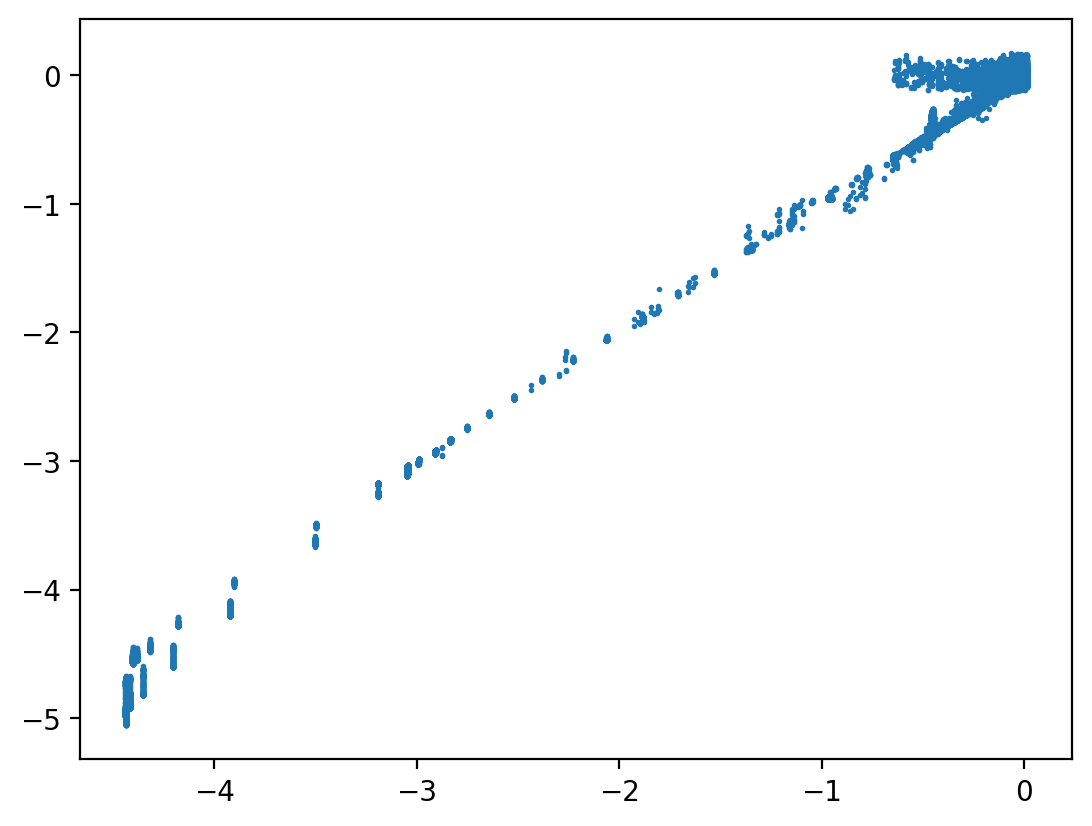

In [12]:
output_mat_exc = output_mat.flatten()
exc_real = (
    data_real["exc1_tr_b3lyp"] + data_real["exc_tr"] - data_real["exc_tr_b3lyp"]
).flatten()

plt.scatter(exc_real, output_mat_exc, s=1)

5451


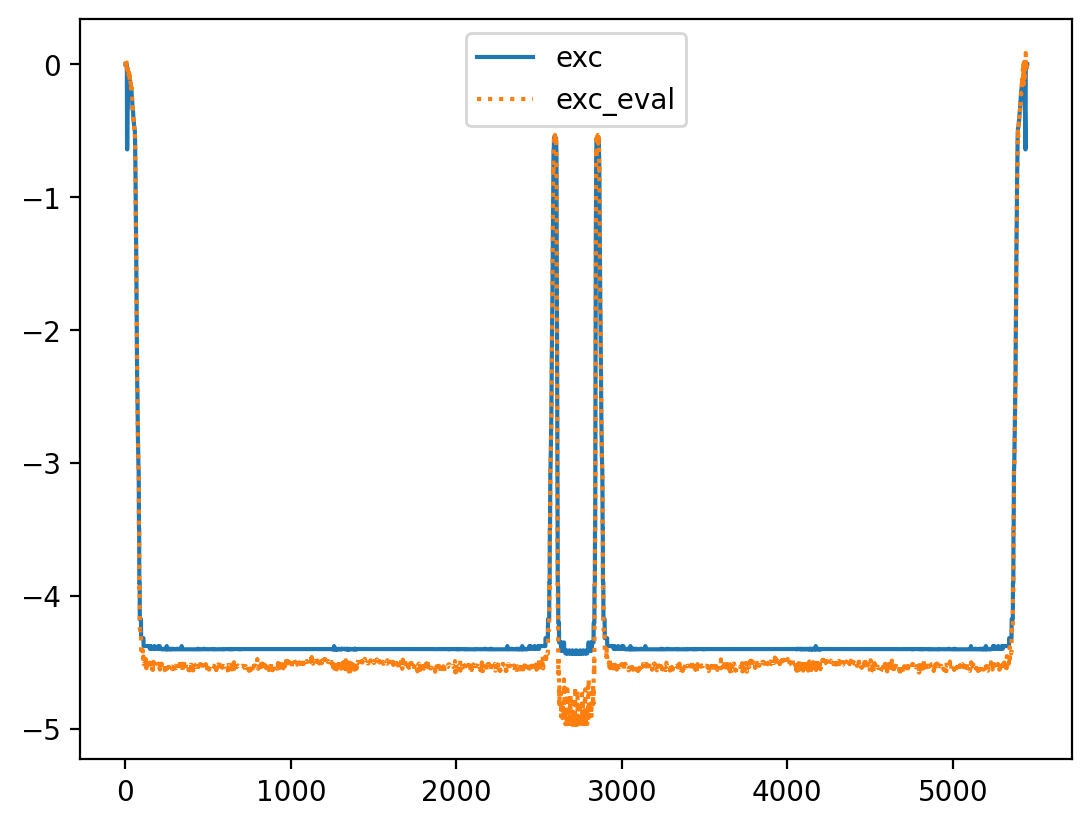

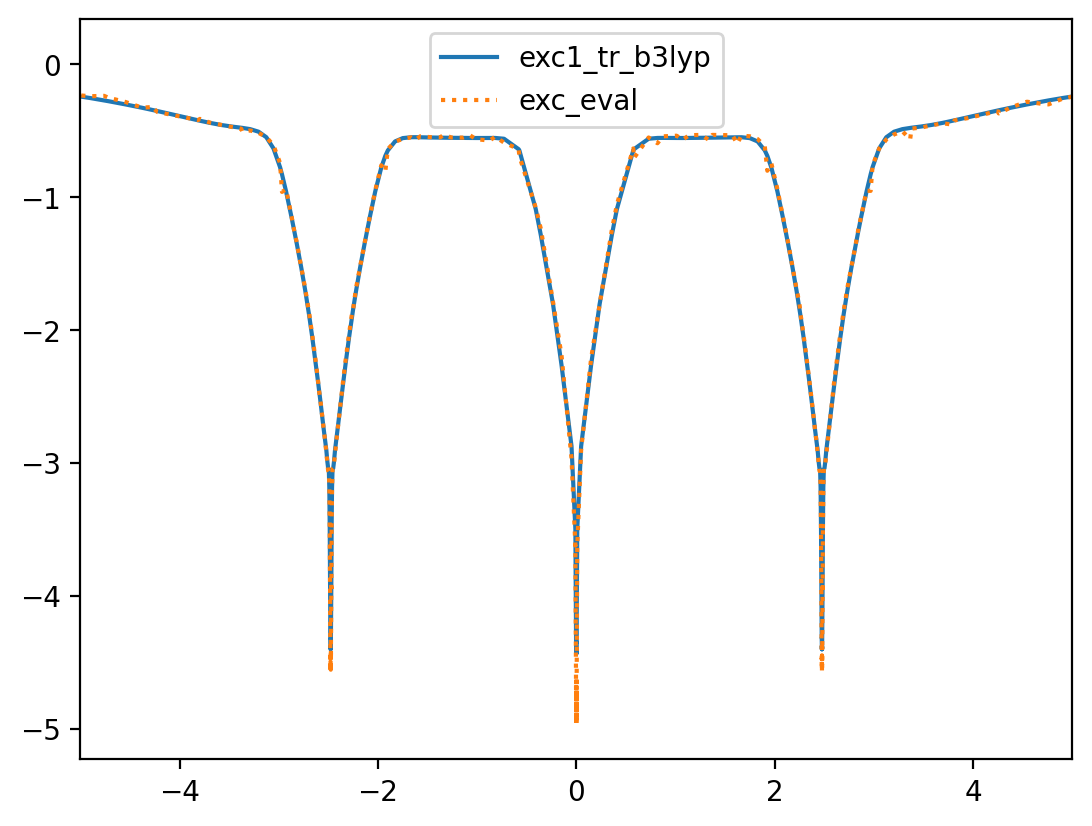

In [13]:
# output_mat_exc_real = data_real["exc_tr_b3lyp"].copy()
# output_mat_exc = output_mat.copy()

dm_weight = dft2cc.grids.vector_to_matrix(scf_rho_r)
output_mat_exc = output_mat.copy()
exc_real = data_real["exc1_tr_b3lyp"] + data_real["exc_tr"] - data_real["exc_tr_b3lyp"]
rho_inv = data_real["rho_inv"]

index_ = np.where(
    (np.abs(dft2cc.grids.coords[:, 1]) < 1e-3)
    & (np.abs(dft2cc.grids.coords[:, 2]) < 1e-3)
)

sort_ = np.argsort(dft2cc.grids.coords[:, 0][index_])
x = dft2cc.grids.coords[:, 0][index_][sort_]
y12 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_][sort_]
y13 = (dft2cc.grids.matrix_to_vector(exc_real))[index_][sort_]

plt.plot(y13, label="exc")
plt.plot(y12, ":", label="exc_eval")
# plt.plot(x, label="x")
plt.legend(loc="best")
print(len(x))
plt.savefig(f"../manu/figures/{name_mol}-ai.pdf")
plt.show()
plt.close()

plt.plot(x, y13, label="exc1_tr_b3lyp")
plt.plot(x, y12, ":", label="exc_eval")
# plt.xlim(-0.5, 0.5)
plt.legend(loc="best")
plt.xlim(-5, 5)
plt.savefig(f"../manu/figures/{name_mol}.pdf")
plt.show()
plt.close()

In [4]:
# print((output_mat_exc - output_mat_exc_real))

In [8]:
# # molecular[0][2] = 0
# molecular

# #
# input_mat = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]).reshape(3, 3)
# arr = np.arange(len(input_mat))
# np.random.shuffle(arr)
# print(input_mat, arr)

# input_mat[:, :] = input_mat[arr, :]
# print(input_mat)

# input_mat[arr, :] = input_mat[:, :]
# print(input_mat)

5404


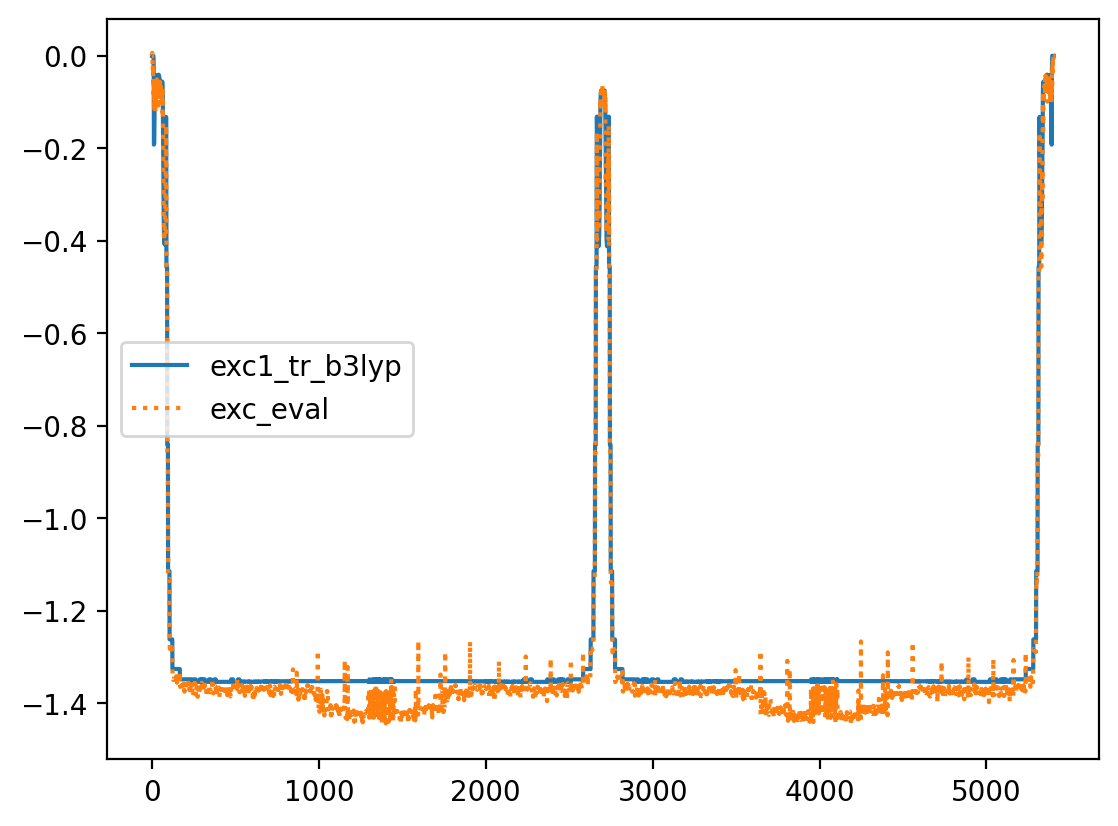

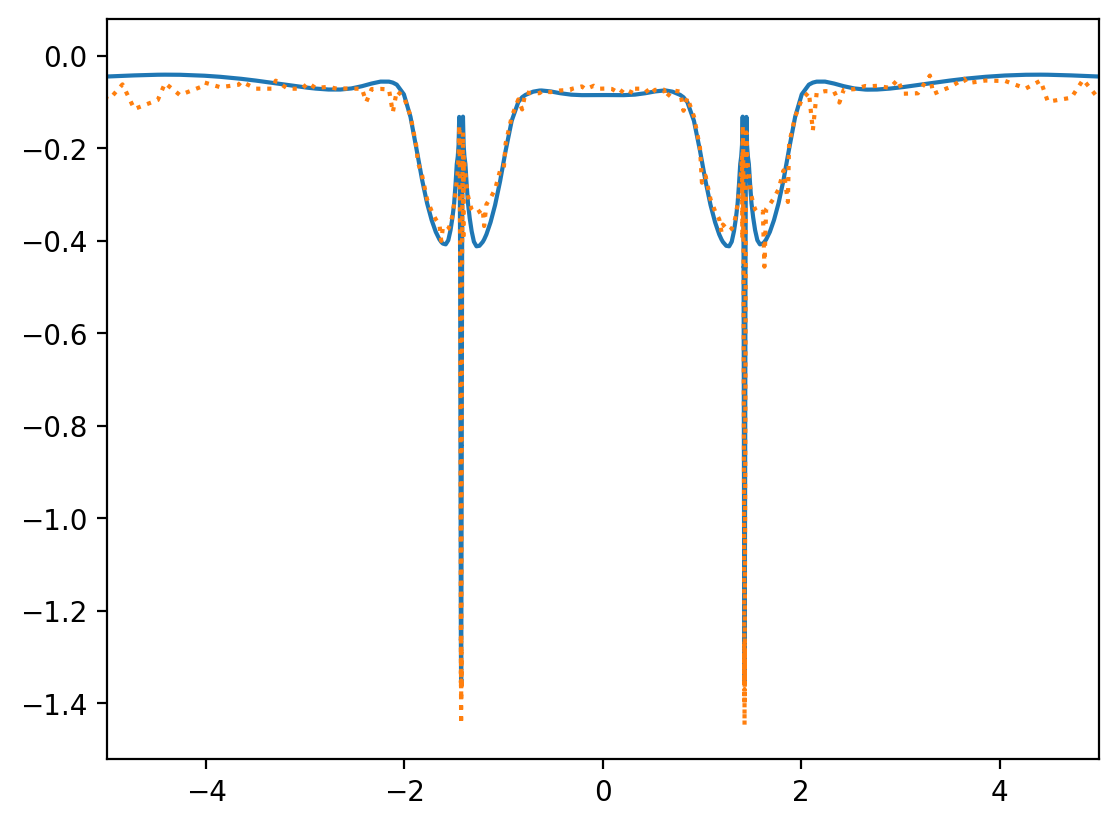

In [9]:
# output_mat_exc_real = data_real["exc1_tr_b3lyp"].copy()
# output_mat_exc = output_mat.copy()

dm_weight = dft2cc.grids.vector_to_matrix(scf_rho_r)
output_mat_exc = output_mat
exc_real = data_real["exc1_tr_b3lyp"]
rho_inv = data_real["rho_inv"]

index_ = np.where(
    (np.abs(dft2cc.grids.coords[:, 1]) < 1e-3)
    & (np.abs(dft2cc.grids.coords[:, 2]) < 1e-3)
)

sort_ = np.argsort(dft2cc.grids.coords[:, 0][index_])
x = dft2cc.grids.coords[:, 0][index_][sort_]
y12 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_][sort_]
y13 = (dft2cc.grids.matrix_to_vector(exc_real))[index_][sort_]

plt.plot(y13, label="exc1_tr_b3lyp")
plt.plot(y12, ":", label="exc_eval")
plt.plot(x, label="x")
plt.legend(loc="best")
print(len(x))
plt.savefig(f"../manu/figures/{name_mol}-ai.pdf")
plt.show()
plt.close()

plt.plot(x, y13, label="exc1_tr_b3lyp")
plt.plot(x, y12, ":", label="exc_eval")
# plt.xlim(-0.5, 0.5)
plt.xlim(-5, 5)
plt.savefig(f"../manu/figures/{name_mol}.pdf")
plt.show()
plt.close()

12344
12344


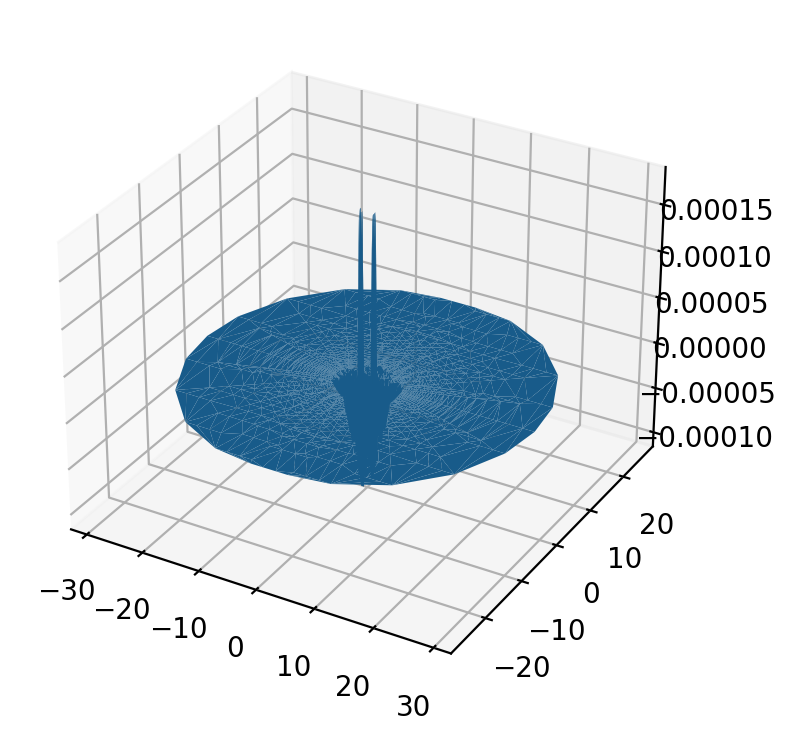

In [ ]:
index_ = np.where((np.abs(dft2cc.grids.coords[:, 2]) < 1e-4))
x = dft2cc.grids.coords[:, 0][index_]
y = dft2cc.grids.coords[:, 1][index_]
print(len(x))

z11 = (dft2cc.grids.matrix_to_vector(output_mat_exc))[index_]
z12 = (dft2cc.grids.matrix_to_vector(output_mat_exc_real))[index_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(x, y, z11 - z12, label="exc")
# ax.plot_trisurf(x, y, z11, label="exc")
# ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.set_xlim(-5, 5)
# ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [ ]:
np.max(np.abs(z11 - z12))

0.9352685484072125